# EIGSEP Suspension and Horizon Modeling

Aaron Parsons

In [1]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import LightSource
from mayavi import mlab
# eigsep_terrain is available at https://github.com/AaronParsons/eigsep_terrain.git
from eigsep_terrain.marjum_dem import MarjumDEM as DEM
import eigsep_terrain as et
import linsolve
import scipy.ndimage as ndi
import os
import tqdm
mlab.init_notebook()

%matplotlib widget

Notebook initialized with ipy backend.


In [61]:
CACHE_FILE = 'marjum_dem.npz'
CACHE_HORIZON_FILENAME = 'marjum_horizon_area.npz'

TETHER_MAX = 300 # m, absolute maximum for tether length; don't consider longer than this
H_MIN = 100 # m, minimum antenna height off ground
H_MAX = 150 # m, maximum antenna height off ground
#THETA_MIN = np.deg2rad(20) # radians, minimum tether inclination angle
THETA_MIN = np.deg2rad(15) # radians, minimum tether inclination angle
N_BINS = 256  # number of azimuthal bins to group pixels into for finding opposing tether points
view_rng = 400 # m

dem = DEM(cache_file=CACHE_FILE)

In [3]:
def color_str2tup(s):
    r, g, b = s[0:2], s[2:4], s[4:6]
    return tuple(map(lambda x: int(x, base=16) / 255, (r, g, b)))

def plot_img(ax, data, res=dem.res, xlabel=True, ylabel=True,
             colorbar=False, cmap='terrain', erng=None, nrng=None, **kw):
    '''Plot maps with standard format.'''
    if nrng is None:
        nrng = (0, data.shape[0] * res)
    if erng is None:
        erng = (0, data.shape[1] * res)
    extent = erng + nrng
    im = ax.imshow(data, extent=extent, cmap=cmap, origin='lower', interpolation='nearest', **kw)
    if colorbar:
        plt.colorbar(im)
    if xlabel:
        ax.set_xlabel('East [m]')
    if ylabel:
        ax.set_ylabel('North [m]')

In [4]:
def find_neighboring_cliff_height(data, r_sus=200, res=dem.res):
    """d_sus: m, maximum suspension radius."""
    dker = int(np.around(r_sus / res))
    # find height of cliffs to either side (UL/DR, or UR/DL)
    mx00 = ndi.maximum_filter(data, size=(dker+1,dker+1), origin=(-dker//2,-dker//2))
    mx01 = ndi.maximum_filter(data, size=(dker+1,dker+1), origin=(-dker//2, dker//2))
    mx10 = ndi.maximum_filter(data, size=(dker+1,dker+1), origin=( dker//2,-dker//2))
    mx11 = ndi.maximum_filter(data, size=(dker+1,dker+1), origin=( dker//2, dker//2))
    mx00_11 = np.where(mx00 < mx11, mx00, mx11)
    mx01_10 = np.where(mx01 < mx10, mx01, mx10)
    mx = np.where(mx00_11 > mx01_10, mx00_11, mx01_10)  # best estimate of cliff heights to either side
    return mx

In [31]:
def dist(a, b):
    return np.linalg.norm(b - a)

def alt(a, b):
    return b[-1] - a[-1]

def az(a, b):
    return np.arctan2(b[1] - a[1], b[0] - a[0])

In [5]:
# Survey points from July 2024 site
SURVEY_PNTS = {
    'A': '+039.241127, -113.392966, 1748',  # ~3m south of antenna 1
    'B': '+039.239895, -113.395416, 1728',  # ~3m south of antenna 2
    'O': '+039.241514, -113.395236, 1804',  # outlook, west canyon
    'W': '+039.241107, -113.395233, 1790',  # anchor, west
    'E': '+039.240712, -113.393846, 1776',  # anchor, east
}

dem.add_survey_points(SURVEY_PNTS)
# interpolate an estimated point for where the July 2024 antenna was suspended
dem['M'] = dem.interp_alt(*((dem['W'] + dem['E'])[:2] / 2), return_vec=True)

dem['P'] = dem.interp_alt(1644, 2032, return_vec=True)  # site 1
#dem['P'] = dem.interp_alt(1744, 2262, return_vec=True)  # site 2
#dem['P'] = dem['M']  # July 2024 site

crds = None

## Determine Antenna Height

In this section, we determine the antenna height across the map that places all terrain formations at a distance 100 m from the antenna.

This is done by solving the quadratic equation for height above the ground, $h$, as
\begin{equation}
\left(h - z(\vec r)\right)^2 + \left|\vec r\right|^2\ge h_0^2,
\end{equation}
where $h_0$ is the specified (100 m) distance requirement, $\vec r$ is the 2D (east/north) displacement vector 
from the location in question, and $z(\vec r)$ is the terrain height as a function of displacement.

Algebraic manipulation gives the closed form solution:
\begin{equation}
h = {\rm max}\left(z(\vec r) + \sqrt{h_0^2-\left|\vec r\right|^2}\right),
\end{equation}
for $\left|\vec r\right|\le h_0$.

In [6]:
f = 32
E, N, U = dem.get_tile(mesh=False, decimate=f)
res = dem.res * f
# pick pixels that have opposing cliffs above a certain height
mx = find_neighboring_cliff_height(U, res=res)
mask1 = np.where(mx - U > H_MIN)
print(U.size, mask1[0].size)

47000 3804


In [7]:
# quick filter on whether points see to corner of map boundaries
_n, _e = mask1

def filter_pixels(_n, _e, U, h=H_MIN, nb=5, npnts=350):
    _mask = np.ones(_n.shape, dtype='bool')
    n_bound = np.linspace(0, U.shape[0] - 1, nb)
    e_bound = np.linspace(0, U.shape[1] - 1, nb)
    _hs = h + U[_n, _e]
    for i in tqdm.tqdm(range(_n.size)):
        for _nc in (0, U.shape[0] - 1):
            _nis = np.around(np.linspace(_n[i], _nc, npnts)).astype(int)
            for _ec in e_bound:
                _eis = np.around(np.linspace(_e[i], _ec, npnts)).astype(int)
                if not np.any(U[_nis, _eis] > _hs[i]):
                    _mask[i] = 0
                    break
            if _mask[i] == 0: break
        if _mask[i] == 0: continue
        for _ec in (0, U.shape[1] - 1):
            _eis = np.around(np.linspace(_e[i], _ec, npnts)).astype(int)
            for _nc in n_bound:
                _nis = np.around(np.linspace(_n[i], _nc, npnts)).astype(int)
                if not np.any(U[_nis, _eis] > _hs[i]):
                    _mask[i] = 0
                    break
            if _mask[i] == 0: break
    return _mask

In [8]:
_mask = filter_pixels(_n, _e, U)
mask2 = (_n[_mask], _e[_mask])
print(mask1[0].shape, mask2[0].shape)

100%|█████████████████████████████████████| 3804/3804 [00:00<00:00, 4010.55it/s]

(3804,) (385,)


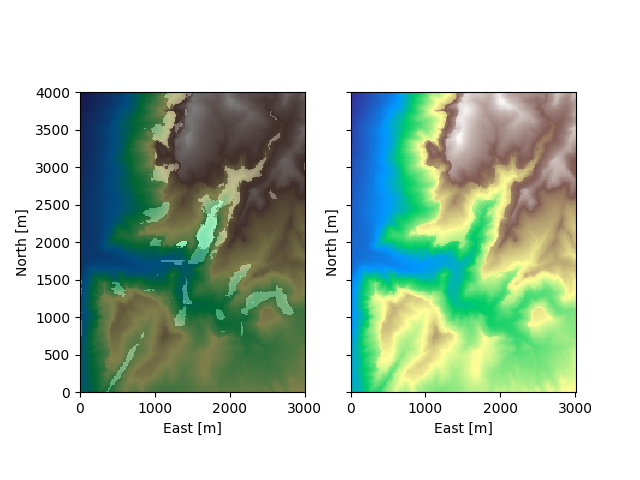

In [9]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
res = dem.res * f
plot_img(axes[0], U, res=res)
_maskview = np.zeros_like(U)
for m in (mask1, mask2):
    _maskview[m[0], m[1]] += 1
plot_img(axes[0], _maskview, cmap='gray', alpha=0.5, res=res)
plot_img(axes[1], U, res=res)

In [10]:
f_prev = f
mask_prev = mask2

for f_new in (8,):
    print(f_new)
    f_step = f_prev // f_new
    f_prev = f_new
    subdiv = np.arange(f_step)
    _de, _dn = np.meshgrid(subdiv, subdiv)
    mask_next = (np.ravel(f_step * mask_prev[0][:,None,None] + _dn), np.ravel(f_step * mask_prev[1][:,None,None] + _de))
    print(mask_prev[0].shape, mask_next[0].shape)
    
    E, N, U = dem.get_tile(mesh=False, decimate=f_new)
    _n, _e = mask_next
    hs = dem.zone_of_avoidance_height(E[_e], N[_n], r_zoa=H_MIN)
    _mask = np.where(hs < H_MAX)[0]
    _n, _e, hs = (_n[_mask], _e[_mask], hs[_mask])
    
    # quick filter on whether points see to corner of map boundaries
    _mask = filter_pixels(_n, _e, U, h=H_MIN)
    mask_next = (_n[_mask], _e[_mask], hs[_mask])
    print(mask_prev[0].size, mask_next[0].size)
    mask_prev = mask_next

8
(385,) (6160,)


100%|█████████████████████████████████████| 1259/1259 [00:00<00:00, 1570.83it/s]

385 1084


In [11]:
_n, _e, _h = mask_next
_mask = []
for i in tqdm.tqdm(range(_n.size)):
    try:
        #anchors = dem.find_anchors(E[_e[i]], N[_n[i]], zs[_n[i], _e[i]], n_anchors=2, r_anchor_max=TETHER_MAX, decimate=f)
        anchors = dem.find_anchors(E[_e[i]], N[_n[i]], U[_n[i],_e[i]] + _h[i], n_anchors=2, r_anchor_max=TETHER_MAX, decimate=f)
        assert len(anchors) > 0
        _mask.append(1)
    except(IndexError, AssertionError):
        _mask.append(0)
_mask = np.array(_mask, dtype=bool)
mask5 = (_n[_mask], _e[_mask], _h[_mask])
print(mask_next[0].size, mask5[0].size)

  0%|                                                  | 0/1084 [00:00<?, ?it/s]/home/aparsons/.local/lib/python3.10/site-packages/eigsep_terrain/dem.py:172: RuntimeWarning: invalid value encountered in multiply
  anchors_e = e0 + r_anchors * np.sin(az_anchors)
100%|█████████████████████████████████████| 1084/1084 [00:00<00:00, 2433.12it/s]

1084 1084


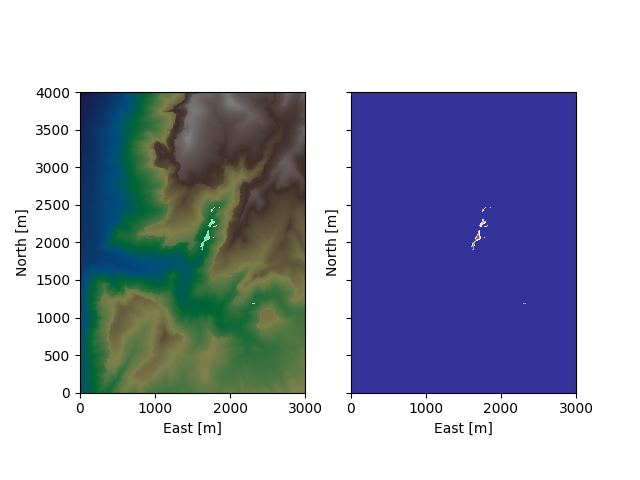

In [12]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
res = dem.res * f_new
plot_img(axes[0], U, res=res)
_maskview = np.zeros_like(U)
heights = np.zeros_like(U)
heights[mask5[0], mask5[1]] = mask5[2]
for m in (mask_next, mask5):
    _maskview[m[0], m[1]] += 1
plot_img(axes[0], _maskview, cmap='gray', alpha=0.5, res=res)
plot_img(axes[1], heights, res=res)

In [21]:
# Calculate the horizon angle of the terrain surround the antenna
harea = np.ones_like(U) * 1e5 # km^2
hs = np.zeros_like(U)
if not os.path.exists(CACHE_HORIZON_FILENAME):
    _n, _e, _h = mask5
    #_mask = np.where(np.logical_and(N[_n] > 1700, N[_n] < 2700))[0]
    #_n, _e, _h = _n[_mask], _e[_mask], _h[_mask]
    for i in tqdm.tqdm(range(_n.size)):
        horizon_angles, crds = dem.calc_horizon(E[_e[i]], N[_n[i]], _h[i] + U[_n[i],_e[i]], crds=crds)
        vis_dist = et.utils.horizon_angle_to_distance(horizon_angles, 10e3)
        _harea = np.sum(np.pi * vis_dist ** 2 / vis_dist.size) / 1e6 # km^2
        harea[_n[i], _e[i]] = _harea
    np.savez(CACHE_HORIZON_FILENAME, e=E[_e], n=N[_n], h=_h, u=_h + U[_n,_e], horizon_area=harea[_n,_e])
else:
    npz = np.load(CACHE_HORIZON_FILENAME)
    n_px, e_px = dem.m2px(npz['n'], npz['e'], res=res)
    harea[n_px, e_px] = npz['horizon_area']
    hs[n_px, e_px] = npz['h']

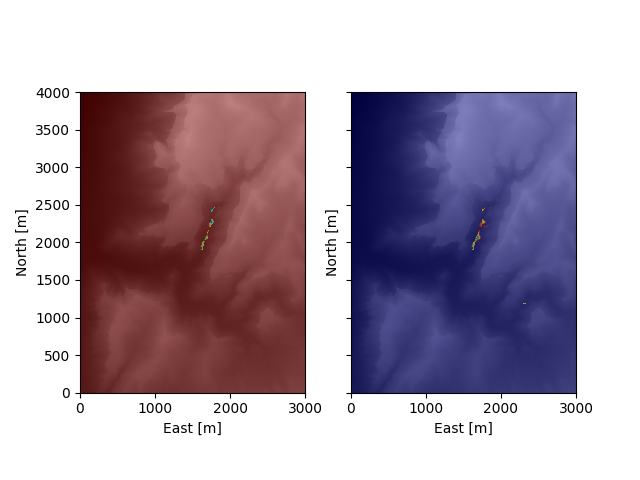

In [23]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
plot_img(axes[0], U, res=res, cmap='gray')
plot_img(axes[0], np.log10(harea), res=res, vmax=5, cmap='jet', alpha=0.5)
plot_img(axes[1], U, res=res, cmap='gray')
plot_img(axes[1], hs, res=res, vmax=H_MAX, vmin=H_MIN, cmap='jet', alpha=0.5)

In [24]:
#e0, n0, u0 = dem['P']
_mask = np.where(np.logical_and(npz['horizon_area'] < 40e3, npz['h'] < 130))[0]
es, ns, us, hs = npz['e'][_mask], npz['n'][_mask], npz['u'][_mask], npz['h'][_mask]
harea = npz['horizon_area'][_mask]
inds = np.argsort(harea)
es, ns, us, hs =  es[inds], ns[inds], us[inds], hs[inds]

#print(e0, n0)
#print(dem['P'])

In [63]:
#i = 0
i = 2
e0, n0, u0 = dem['P'] = np.array([es[i], ns[i], us[i]])
h = hs[i]

In [65]:
# solve for good tether points around antenna location
# pick a minimum altitude after selecting for low antenna height off ground
e0, n0, u0 = pltfm = dem['P']
print(f'Best location: {e0: 3.0f} m East, {n0: 3.0f} m North, {u0: 3.0f} m Up ({h: 3.0f} m off ground)')

# Find tether points
anchors, boundaries = dem.find_anchors(e0, n0, u0, n_anchors=2, r_anchor_max=TETHER_MAX, min_angle=THETA_MIN, boundary=True)
print(anchors)
dem['X'] = anc_e = dem.interp_alt(*anchors[0], return_vec=True)
dem['Y'] = anc_w = dem.interp_alt(*anchors[1], return_vec=True)

print(f"Distance to Anchor 1 = {dist(pltfm, anc_e): 3.0f} m, Extended length = {dist(pltfm - h, anc_e): 3.0f} m")
print(f"Distance to Anchor 2 = {dist(pltfm, anc_w): 3.0f} m, Extended length = {dist(pltfm - h, anc_w): 3.0f} m")

Best location:  1740 m East,  2264 m North,  1833 m Up ( 124 m off ground)
[(1919.7286092765532, 2240.3382797008326), (1538.1654693810367, 2290.572020055366)]
Distance to Anchor 1 =  187 m, Extended length =  362 m
Distance to Anchor 2 =  210 m, Extended length =  244 m


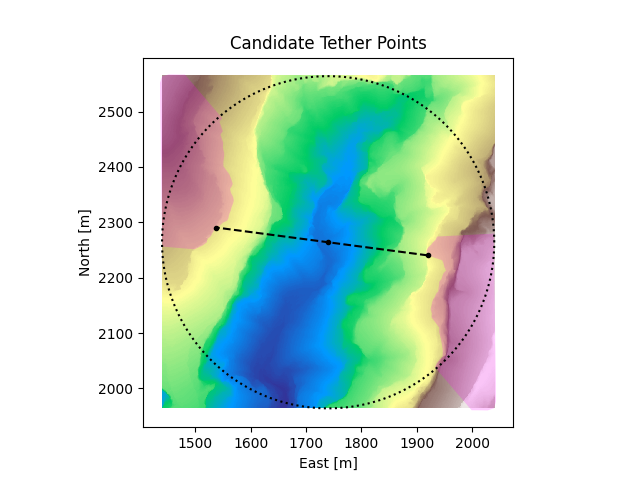

In [66]:
fig, ax = plt.subplots()
e1, n1 = anchors[0]
e2, n2 = anchors[1]
erng = (e0 - TETHER_MAX, e0 + TETHER_MAX)
nrng = (n0 - TETHER_MAX, n0 + TETHER_MAX)
_E, _W, _U = dem.get_tile(erng_m=erng, nrng_m=nrng, mesh=True)
plot_img(ax, _U, erng=erng, nrng=nrng)
plt.plot([e0, e1, e2], [n0, n1, n2], 'k.')
plt.plot([e1, e2], [n1, n2], 'k--')
th = np.linspace(0, 2 * np.pi, 200)
_r = 300
plt.plot(e0 + _r * np.cos(th), n0 + _r * np.sin(th), 'k:')

for cnt in range(len(anchors)):
    ax.fill(boundaries[cnt, :, 0], boundaries[cnt, :, 1], 'magenta', alpha=0.2)
_ = plt.title('Candidate Tether Points')

In [67]:
# Calculate the horizon angle of the terrain surround the antenna
horizon_angles, crds = dem.calc_horizon(e0, n0, u0, crds=crds)
vis_dist = et.utils.horizon_angle_to_distance(horizon_angles, 10e3)
print(f'Estimated Viewable Airplane Area {np.sum(np.pi * vis_dist ** 2 / vis_dist.size) / 1e6:3.0f} km^2')

Estimated Viewable Airplane Area 19844 km^2


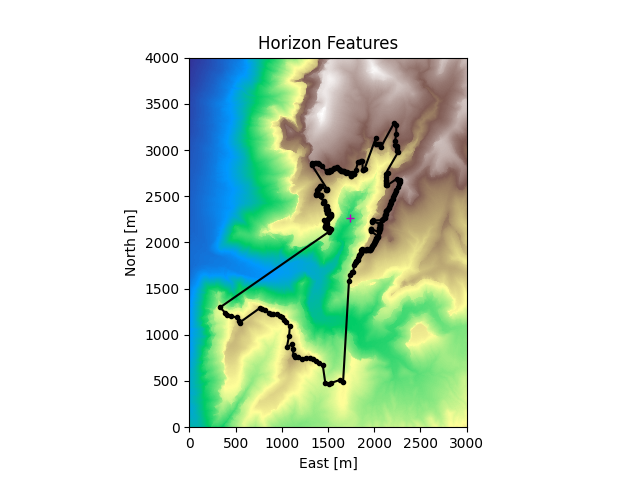

In [68]:
fig, ax = plt.subplots()
plot_img(ax, dem.data, dem.res)
plt.plot(crds[1], crds[0], 'k.-')
plt.plot([e0], [n0], 'm+')
_ = plt.title('Horizon Features')

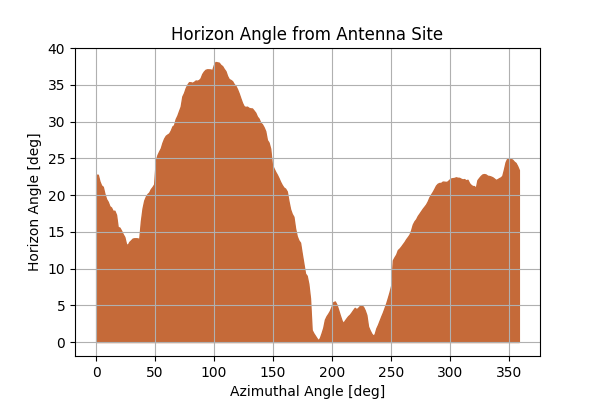

In [69]:
plt.figure(figsize=(6,4))
plt.title('Horizon Angle from Antenna Site')
plt.fill_between(np.linspace(0, 360, horizon_angles.size, endpoint=False), np.rad2deg(horizon_angles), 0, color=color_str2tup('c56a39'))
plt.xlabel('Azimuthal Angle [deg]')
plt.ylabel('Horizon Angle [deg]')
_ = plt.grid()

In [70]:
E, N, U = dem.get_tile(erng_m=(e0 - view_rng, e0 + view_rng), nrng_m=(n0 - view_rng, n0 + view_rng))

if False:  # enable 3d interactive plot
    TAUPE = color_str2tup('b7c0c9')
    mlab.figure(size=(2*400, 2*320), bgcolor=TAUPE)
    s = mlab.surf(E.T, N.T, U.T, warp_scale=1, vmin=1500, colormap='copper')
    mlab.outline()
    mlab.axes(xlabel='E', ylabel='N', zlabel='U')
    line1 = np.array([anc_e, pltfm])
    line2 = np.array([anc_w, pltfm])
    mlab.plot3d(line1[:,0], line1[:,1], line1[:,2], tube_radius=1)
    mlab.plot3d(line2[:,0], line2[:,1], line2[:,2], tube_radius=1)
    mlab.points3d(*pltfm, color=(1, 0, 1), opacity=0.3, scale_factor=2*R, resolution=64)
    mlab.view(250, 90)
    #mlab.view(270, 0)
else:
    s = None
s

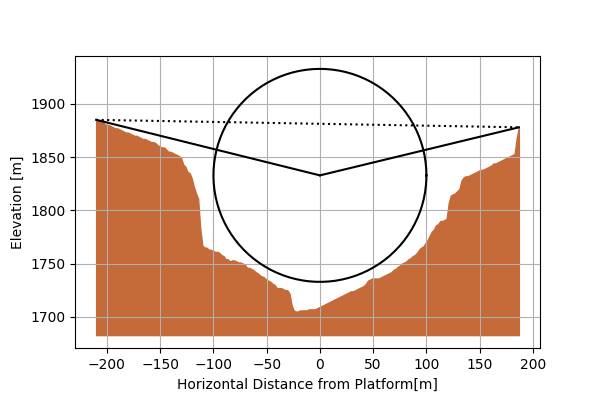

In [71]:
fig, axes = plt.subplots(figsize=(6, 4))
plot_e = np.linspace(anc_w[0], anc_e[0], 200)
plot_n = np.linspace(anc_w[1], anc_e[1], 200)
plot_r = np.linspace(-dist(anc_w, pltfm), dist(anc_e, pltfm), 200)
plt.fill_between(plot_r, dem.interp_alt(plot_e, plot_n), pltfm[-1] - 150, color=color_str2tup('c56a39'))
plt.plot([plot_r[0], plot_r[-1]], [anc_w[-1], anc_e[-1]], 'k:')
plt.plot([plot_r[0], 0], [anc_w[-1], pltfm[-1]], 'k-')
plt.plot([0, plot_r[-1]], [pltfm[-1], anc_e[-1]], 'k-')
th = np.linspace(0, 2 * np.pi, 200)
axes.plot(H_MIN * np.cos(th), pltfm[-1] + H_MIN * np.sin(th), 'k-')
plt.grid()
plt.xlabel('Horizontal Distance from Platform[m]')
plt.ylabel('Elevation [m]')
axes.set_aspect('equal')

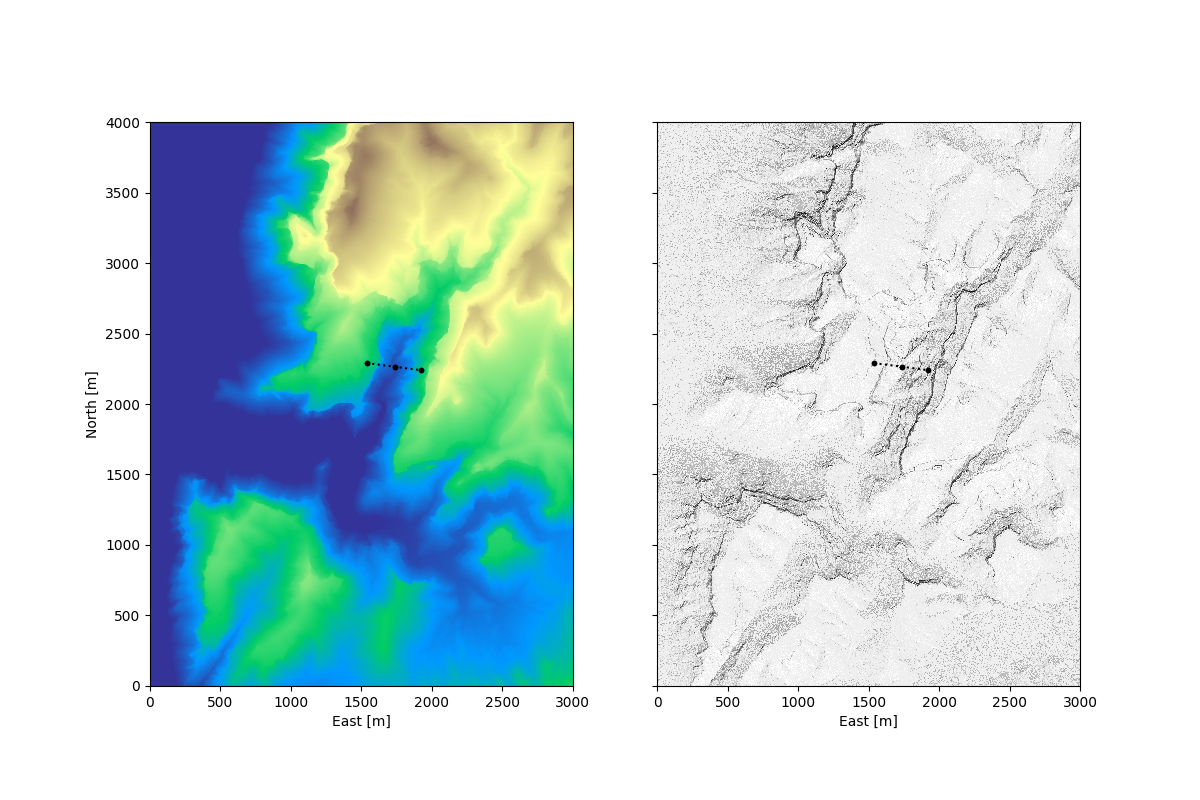

In [72]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 8))
plot_img(axes[0], dem.data, vmin=1670, vmax=2500)
ls = LightSource(azdeg=15, altdeg=65)
plot_img(axes[1], ls.hillshade(dem.data, vert_exag=1), cmap='gray', ylabel=False)

for ax in axes:
    ax.plot(plot_e, plot_n, 'k:')

for k, (_e, _n, _u) in dem.items():
    for ax in axes:
        ax.plot([_e], [_n], 'k.')
        ax.plot([_e], [_n], 'k.')

## Suspension Tethers

In this section we consider anchor points for suspending antennas at the two candidate sites.

The choice of minimum suspension angle impacts where anchors can be placed, but as suspension angles get flatter, increased force is required to hold an antenna platform of a fixed weight:
\begin{equation}
F_{\rm tension} = \frac{mg}{N_{\rm tethers}\sin\phi},
\end{equation}
where $N_{\rm tethers}$ is the number of tethers holding the antenna platform, and $\phi$ is the suspension angle.

In [73]:
units = 'kg'
platform_wgt = 50 # kg
rope_wgt = 20 # kg
tiedown_wgt = 10 # kg
total_wgt = platform_wgt + rope_wgt + 4 * tiedown_wgt

phi_w = np.arcsin(alt(pltfm, anc_w) / dist(anc_w, pltfm))
phi_e = np.arcsin(alt(pltfm, anc_e) / dist(anc_e, pltfm))

d = {}
d['Tw*sw + Te*se'] = total_wgt
d['Tw*cw - Te*ce'] = 0

consts = {
    'sw': np.sin(phi_w),
    'se': np.sin(phi_e),
    'cw': np.cos(phi_w),
    'ce': np.cos(phi_e),
}

ls = linsolve.LinearSolver(d, **consts)
ans = ls.solve()
print(ans)
print(phi_w, phi_e)

{'Tw': 224.79644665122095, 'Te': 224.41715931329935}
0.2507297394197451 0.24404354172526094


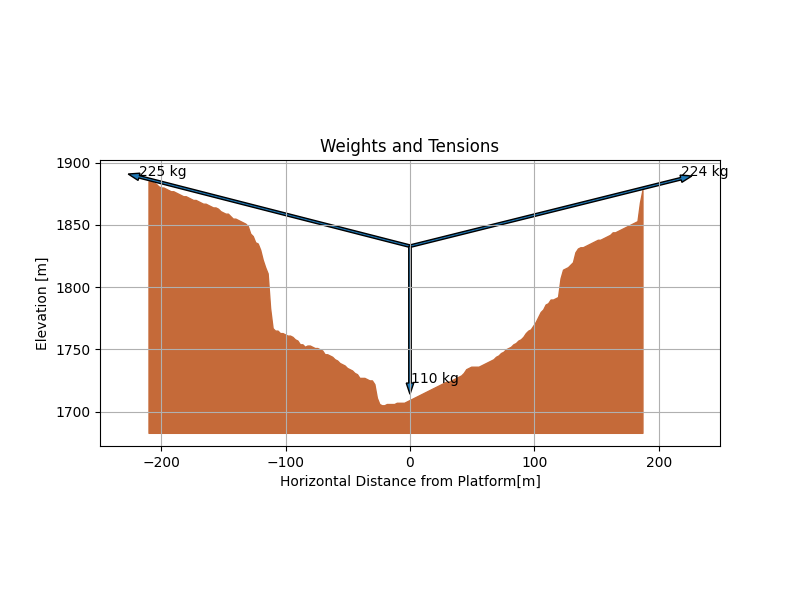

In [74]:
fig, axes = plt.subplots(figsize=(8, 6))
plt.fill_between(plot_r, dem.interp_alt(plot_e, plot_n), pltfm[-1] - 150, color=color_str2tup('c56a39'))
plt.arrow(0, pltfm[-1], -ans['Tw'] * np.cos(phi_w), ans['Tw'] * np.sin(phi_w), width=2)
plt.text(-ans['Tw'] * np.cos(phi_w), 1 + pltfm[-1] + ans['Tw'] * np.sin(phi_w), f'{ans["Tw"]:3.0f} {units}', fontsize=10)
plt.arrow(0, pltfm[-1],  ans['Te'] * np.cos(phi_e), ans['Te'] * np.sin(phi_e), width=2)
plt.text( ans['Te'] * np.cos(phi_e), 1 + pltfm[-1] + ans['Te'] * np.sin(phi_w), f'{ans["Te"]:3.0f} {units}', fontsize=10)
plt.arrow(0, pltfm[-1], 0, -total_wgt, width=2)
plt.text(1, pltfm[-1] - total_wgt, f'{total_wgt:3.0f} {units}', fontsize=10)
plt.grid()
plt.xlabel('Horizontal Distance from Platform[m]')
plt.ylabel('Elevation [m]')
axes.set_aspect('equal')
_ = plt.title('Weights and Tensions')

### Rope Specs
Typical 1/4" Kevlar rope (e.g. https://www.e-rigging.com/_p_3281.html) has a minimum breaking load of 470 kg,
weighs 3.4 kg per 100 m, and costs $40 per 100m.